In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from utils import segpath2path, pairwise_distances, point2segments
from analysis_by_plot import *

In [2]:
import matplotlib.transforms as mtransforms

plt.rcParams['font.family'] = 'DeJavu Serif'
plt.rcParams['font.serif'] = ['Times New Roman']
plt.rcParams['font.size'] = 7.5
plt.rcParams['axes.titlesize'] = 7.5

figw2 = 3.307
figw1 = 6.85


def complete_figure(fig, axes, index):    
    trans = mtransforms.ScaledTranslation(0.02, -0.02, fig.dpi_scale_trans)
    for label, ax in zip(index, axes.flatten()):
        ax.text(0.0, 1.0, '({})'.format(label), transform=ax.transAxes + trans,
                verticalalignment='top', fontfamily='Arial')

In [21]:
var_name = 'noise_sensor' 
# var_name = 'noise_motor'   
goal_idx = -1   
# goal_idx = -28 # near obstacle    

condcode = int(var_name == 'noise_sensor') * 2 + int(goal_idx == -1)
if condcode in (2, 3):
    record_dir = 'sensor_noisefreetrain_robustness_3in1_fixedroute'
elif condcode in (0, 1):
    record_dir = 'motor_robustness_3in1_fixtrainroute'
print(condcode, var_name, goal_idx, record_dir)

3 noise_sensor -1 sensor_noisefreetrain_robustness_3in1_fixedroute


In [22]:
# record_dir = 'motor_robustness_3in1_randinitorn' #### the data source is wrong; this looks just random motor
ls_value = 0, 0.1, 0.2, 0.5, 1, 2, 5, 10, 20, 50

n_condition = len(ls_value)
catchment_radius = 0.372 / 2 ## 0.372 is the wheel axle length of Freight

n_trial = 100
n_epoch_train, n_epoch_test = 125, 500
# ls_model_keys = 'pure-pursuit', 'lamb', 'visual-localisor'
ls_model_name = 'pure-pursuit', 'visual-localisor', 'differential-MB', 'klinokinesis-MB'
ls_color = 'tab:green', 'tab:orange', 'tab:red', 'tab:blue'
n_model = len(ls_model_name)

In [23]:
# data_path = np.load(os.path.join('records', record_dir, 'data_path.npy'), allow_pickle=True)[()]
data_path = np.load(os.path.join('records', record_dir, 'data_path_with_kk.npy'), allow_pickle=True)[()]

In [24]:
data_dist_test2goal, data_min_dist2goal, data_time_min_dist2goal = {}, {}, {}
data_dist_testtrunc2goal = {}
data_time_catchment = {}

for model_name in ls_model_name:
    data_path[model_name]['test'] = (data_path[model_name]['test'].T - data_path[model_name]['test'][:, :, :, 0].T).T
    path_train_init = data_path[model_name]['train'][:, :, :, 0]
#     data_path[model_name]['train'] = (data_path[model_name]['train'].T - path_train_init.T).T
    path_train_goal = data_path[model_name]['train'][:, :, :, goal_idx]
    dist_init2goal = np.linalg.norm(path_train_goal, axis=-1)
    dist_test2goal = np.linalg.norm(path_train_goal[:, :, :, np.newaxis] - data_path[model_name]['test'], axis=2)
    time_min_dist2goal = np.nanargmin(dist_test2goal, axis=2)
    min_dist2goal = np.nanmin(dist_test2goal, axis=2)
    
    data_dist_test2goal[model_name] = dist_test2goal
    data_min_dist2goal[model_name] = min_dist2goal
    data_time_min_dist2goal[model_name] = time_min_dist2goal
    
    nan_mask = (time_min_dist2goal.T < np.tile(np.arange(n_epoch_test), (n_condition, n_trial, 1)).T).T
    nan_mask_path = np.moveaxis(np.tile(nan_mask, (2, 1, 1, 1)), 0, 2)
    data_dist_testtrunc2goal[model_name] = np.where(nan_mask, np.nan, dist_test2goal)
    data_path[model_name]['test_trunc'] = np.where(nan_mask_path, np.nan, data_path[model_name]['test'])

    time_catchment = np.argmax(dist_test2goal <= catchment_radius, axis=-1)
    data_time_catchment[model_name] = np.where(time_catchment == 0, np.nan, time_catchment)

In [25]:
data_dsim_test2train, data_dist_test2path = {}, {}

for model_name in ls_model_name:
    model_dsim_test2train, model_dist_test2path = [], []
    for path_train_val, path_test_val, time_mindist_test2goal_val in zip(data_path[model_name]['train'], 
                                                                          data_path[model_name]['test_trunc'],
                                                                          data_time_min_dist2goal[model_name]):
        val_time_mindist = []
        val_dist_test2path = np.full((n_trial, n_epoch_test), np.nan)
        for trial_idx, (path_train_trial, path_test_trial, time_mindist) in enumerate(zip(path_train_val, 
                                                                                        path_test_val, 
                                                                                        time_mindist_test2goal_val)):
            dsim_test2train, dist_test2path = segpath2path(path_test_trial.T[:time_mindist + 1], path_train_trial.T)
            val_time_mindist.append(dsim_test2train)
            val_dist_test2path[trial_idx, :time_mindist + 1] = dist_test2path
        model_dsim_test2train.append(val_time_mindist)
        model_dist_test2path.append(val_dist_test2path)
        
    data_dsim_test2train[model_name] = np.array(model_dsim_test2train)
    data_dist_test2path[model_name] = np.array(model_dist_test2path)

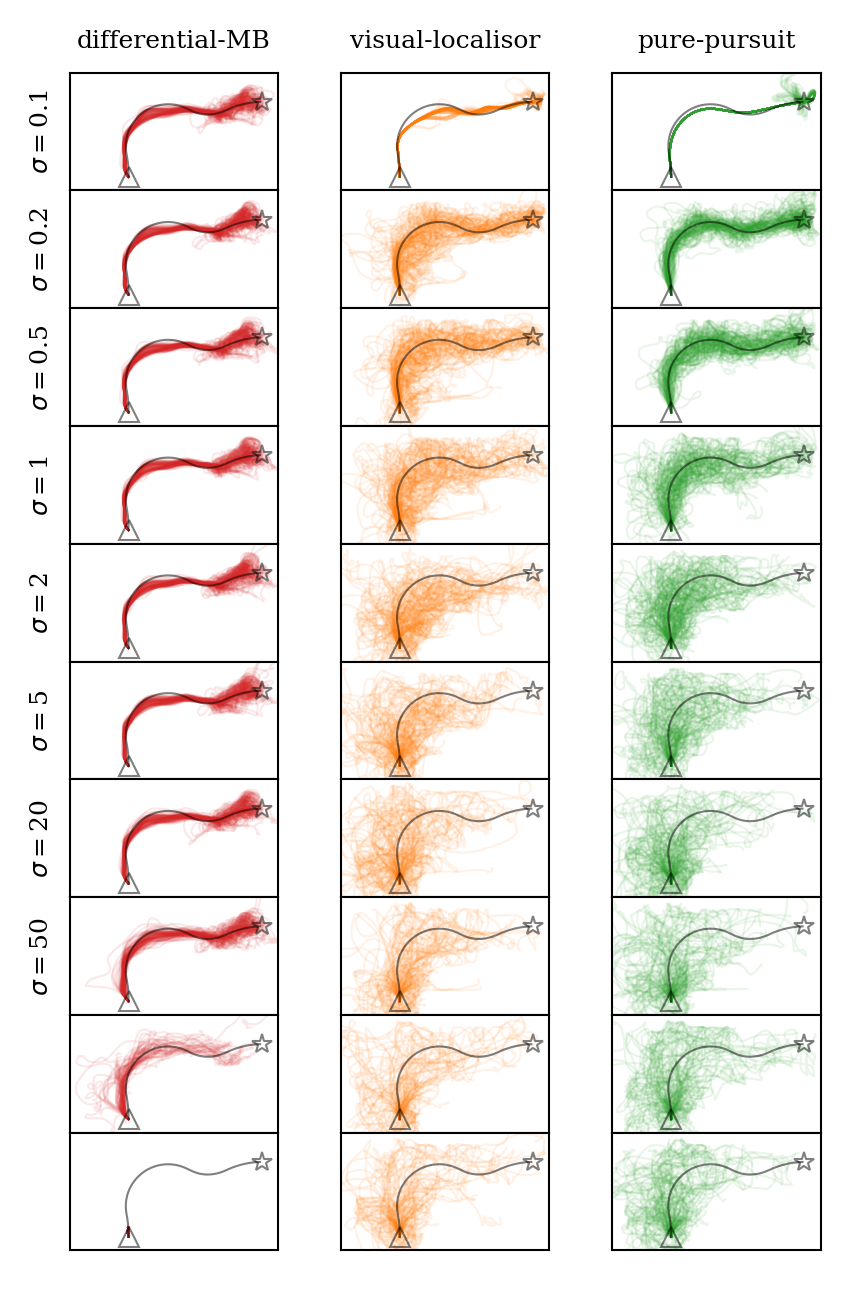

In [49]:
fig, axes = plt.subplots(10, 3, sharex=True, sharey=True, figsize=(3.5, 5.2), dpi=300)
fig.subplots_adjust(hspace=0, wspace=0)
lw = 0.5
alpha = 0.5

for model_name, axrow, color in zip(ls_model_name, axes.T, ls_color):
    for dtp_train, dtp_testtrunc, val, ax in zip(data_path[model_name]['train'], 
                                                            data_path[model_name]['test_trunc'],
                                                            [0, 0.1, 0.2, 0.5, 1, 2, 5, 10, 20, 50], axrow):
        for trial_idx, (path_train, path_test_trunc) in enumerate(zip(dtp_train, dtp_testtrunc)):
            ax.plot(-path_test_trunc[1], path_test_trunc[0], c=color, alpha=0.1, lw=lw)#, ls='dotted')
        
        x, y = -path_train[1], path_train[0]
        ax.plot(x[:goal_idx], y[:goal_idx], c='k', alpha=0.5, lw=lw)
        ax.plot(x[0], y[0], marker='^', c='k', mfc='none', markersize=5, markeredgewidth=lw, alpha=alpha)
        ax.plot(x[goal_idx], y[goal_idx], marker='*', c='k', mfc='none', markersize=5, markeredgewidth=lw, alpha=alpha)


    
for ax in axes.flatten():
    ax.set_aspect('equal')
    ax.set_ylim(-0.3, 2.3)
    ax.set_xlim(-1.3, 3.3)
    ax.set_xticks([])
    ax.set_yticks([])
    
    ax.xaxis.set_tick_params(labelsize=6)
    ax.yaxis.set_tick_params(labelsize=6)
    
    plt.setp(ax.spines.values(), lw=0.5)
    
for ax, val in zip(axes.T[0], [0.1, 0.2, 0.5, 1, 2, 5, 20, 50]):
    ax.set_ylabel('$\sigma=${}'.format(val), fontsize=6)

    
for ax, model_name in zip(axes[0], ls_model_name):
    ax.set_title(model_name, fontsize=6)



In [27]:
model_capitals = 'Klinokinesis-MB', 'Differential-MB', 'Visual-Localisor', 'Pure-pursuit'

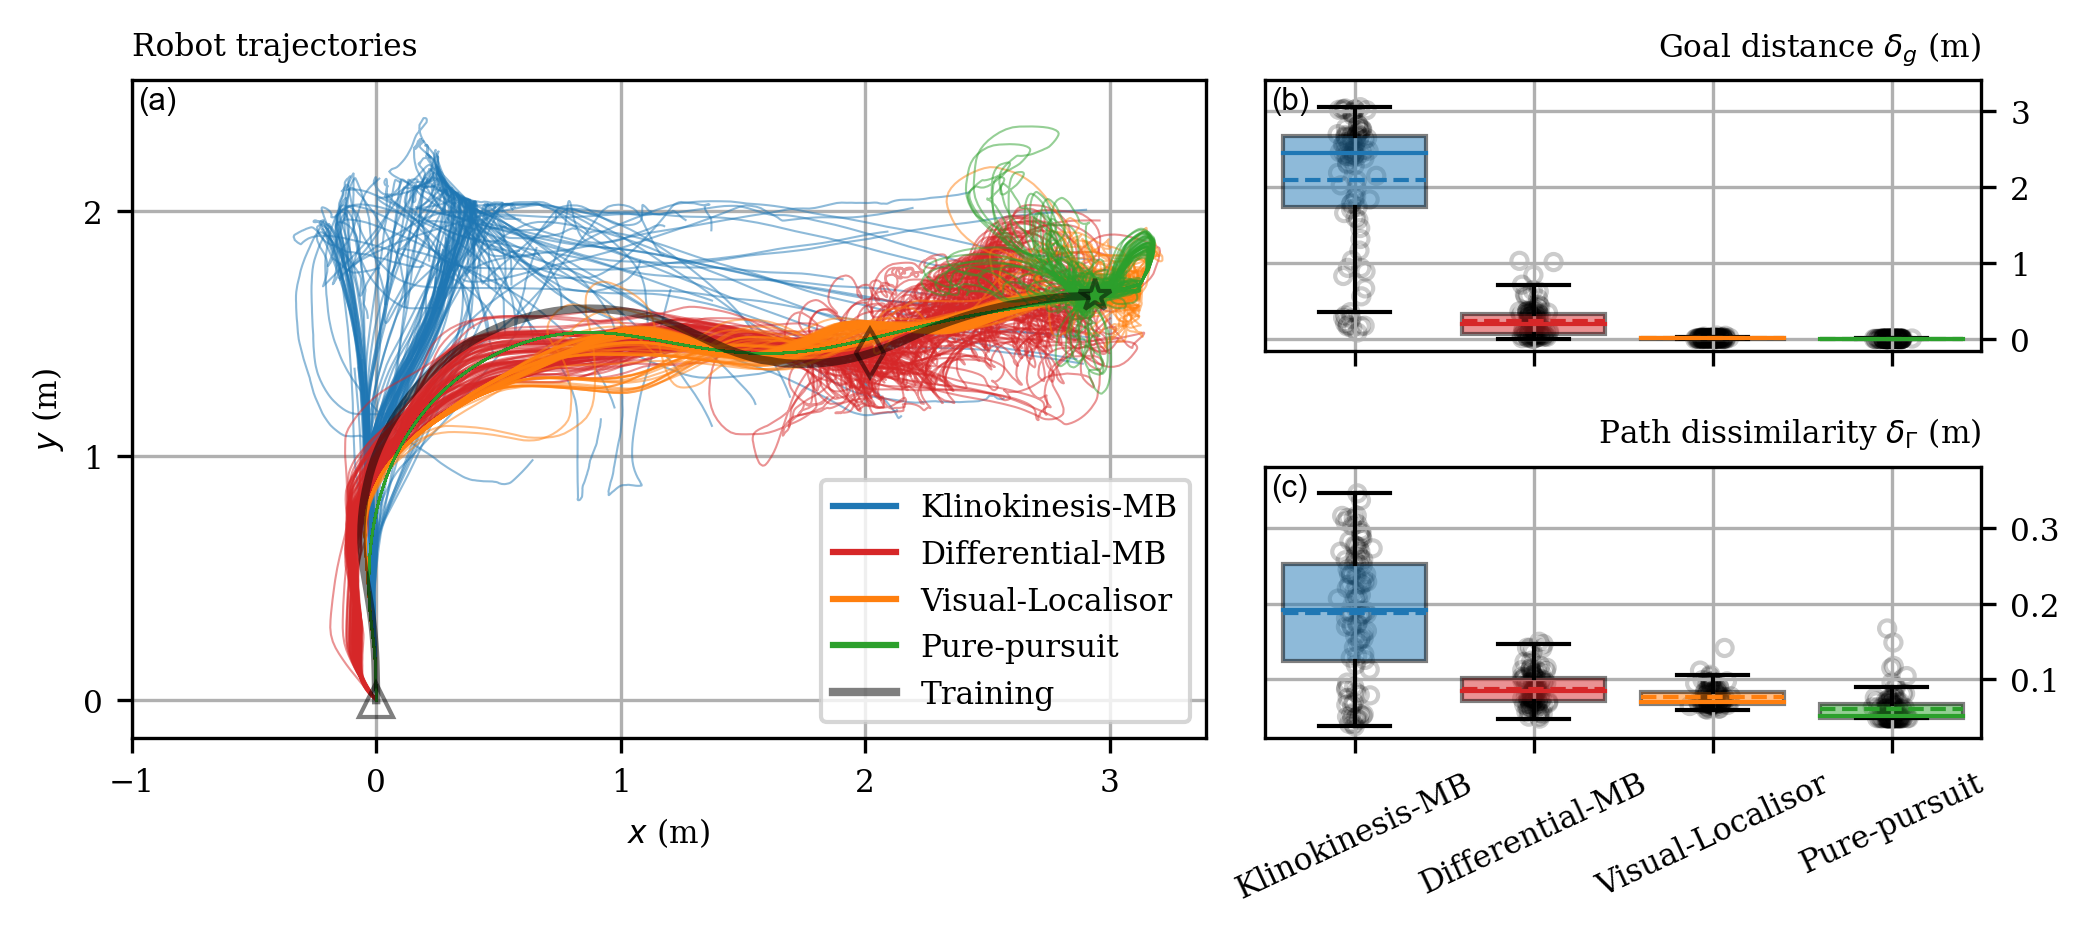

In [28]:
lw = 2

fig, axes = plt.subplot_mosaic('''
                                AAABB
                                AAACC
                                ''', figsize=(figw1,3), dpi=300, layout='constrained')


ls_model_name = 'klinokinesis-MB', 'differential-MB', 'visual-localisor', 'pure-pursuit'
ls_model_abbr = 'kM', 'dM', 'vl', 'pp'
ls_color = 'tab:blue', 'tab:red', 'tab:orange', 'tab:green'

ls_validx = 0, 0, 0, 0

# trajectory
ax = axes['A']

for model_name, color, validx, model_abbr in zip(ls_model_name, ls_color, ls_validx, model_capitals):          
    dtp_train, dtp_test_trunc = [data_path[model_name][phase][validx] for phase in ('train', 'test_trunc')]
        
    for trial_idx, path_test_trunc in enumerate(dtp_test_trunc):
        ax.plot(-path_test_trunc[1], path_test_trunc[0], c=color, alpha=0.5, lw=0.5)
            
    ax.plot([], [], c=color, label=model_abbr)
    
alpha = 0.5    
mkrs = 8
path_train = data_path['pure-pursuit']['train'][0]
ax.plot(-path_train[0][1, :goal_idx], path_train[0][0, :goal_idx], c='k', label='Training', lw=lw, alpha=alpha)
ax.plot(-path_train[0][1, 0], path_train[0][0, 0], marker='^', c='k', mfc='none', markersize=mkrs, markeredgewidth=lw/2, alpha=alpha)
ax.plot(-path_train[0][1, goal_idx], path_train[0][0, goal_idx], marker='*', c='k', mfc='none', markersize=mkrs, markeredgewidth=lw/2, alpha=alpha)
ax.plot(-path_train[0][1, -28], path_train[0][0, -28], marker='d', c='k', mfc='none', markersize=mkrs, markeredgewidth=lw/2, alpha=alpha)

ax.set_xlabel('$x$ (m)')
ax.set_ylabel('$y$ (m)')
ax.set_xticks(np.arange(-1, 3.1, 1))
ax.set_yticks(np.arange(0, 2.1, 1))
ax.set_aspect('equal', adjustable='datalim')    
ax.set_title('Robot trajectories', loc='left')
ax.legend()


    
for ak, dataname, tit in zip('BC', 
                    (data_min_dist2goal, data_dsim_test2train),
                    ('Goal distance $\delta_g$ (m)', 'Path dissimilarity $\delta_\Gamma$ (m)')):
    ax = axes[ak]
    myboxplot(ax, [dataname[_][0] for _ in ls_model_name], ['kM', 'dM', 'vl', 'pp'], ls_color, 0.2, 15)
    ax.set_xticklabels(model_capitals, rotation=25)
#     ax.set_ylabel(tit)
    ax.set_title(tit, loc='right')
    ax.yaxis.tick_right()
#     ax.yaxis.set_label_position('right')

axes['B'].set_xticklabels([])
    
for ax in axes.values():
    ax.grid()
    
    

axes['B'].set_ylim(top=3.4)
axes['C'].set_ylim(top=0.38)

axs = np.array(list([ax for ax in axes.values()]))
complete_figure(fig, axs, 'abc')

NameError: name 'modal_capitals' is not defined

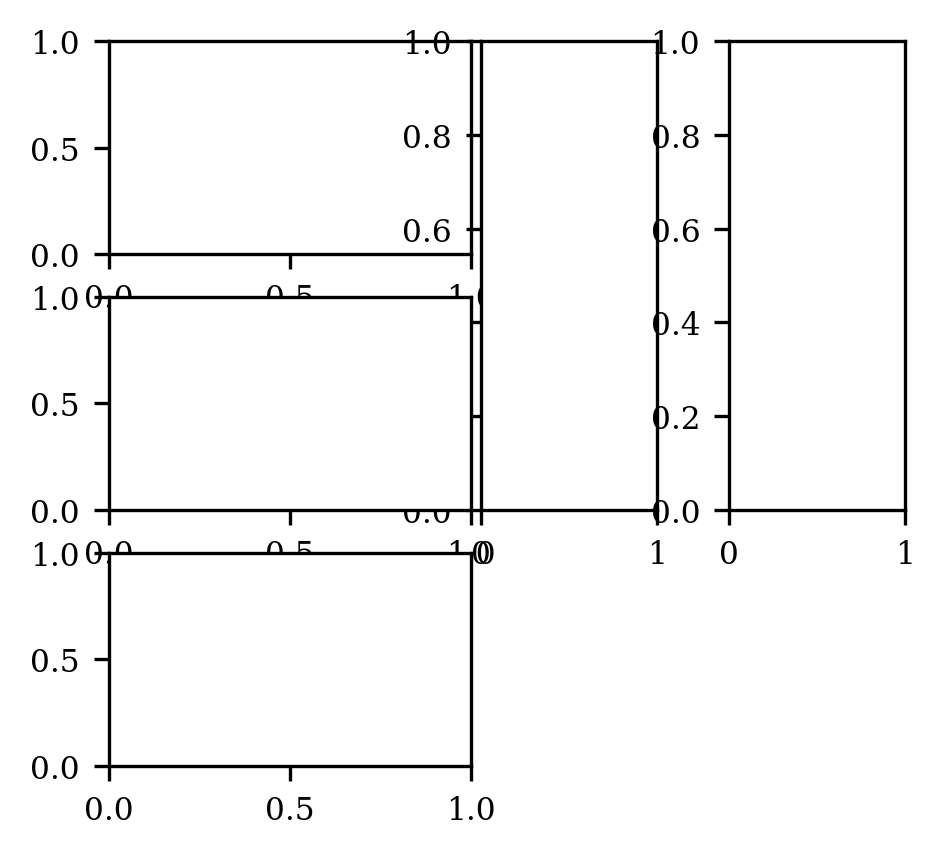

In [29]:
lw = 1

fig, axes = plt.subplot_mosaic('''
                                AAAAAADDD.EEE
                                BBBBBBDDD.EEE
                                CCCCCC.......
                                ''', figsize=(figw1/2, 3.2), dpi=300)


ls_model_name = 'differential-MB', 'visual-localisor', 'pure-pursuit'
ls_color = 'tab:red', 'tab:orange', 'tab:green'


ls_validx = np.full(3, 7)

# trajectory
# ax = axes['A']

for ak, model_name, color, validx, mn in zip('ABC', ls_model_name, ls_color, ls_validx, modal_capitals[1:]):
    ax = axes[ak]
    dtp_train, dtp_test_trunc = [data_path[model_name][phase][validx] for phase in ('train', 'test_trunc')]
        
    for trial_idx, path_test_trunc in enumerate(dtp_test_trunc):
        ax.plot(-path_test_trunc[1], path_test_trunc[0], c=color, alpha=0.2, lw=lw)
            
    ax.plot([], [], c=color, label=model_name)
    
    alpha = 0.5    
    path_train = data_path['pure-pursuit']['train'][0]
    ax.plot(-path_train[0, :, :goal_idx][1], path_train[0, :, :goal_idx][0], c='k', label='training', lw=lw, alpha=alpha)
    ax.plot(-path_train[0, :, 0][1], path_train[0, :, 0][0], marker='^', c='k', mfc='none', markersize=10, markeredgewidth=lw/2, alpha=alpha)
    ax.plot(-path_train[0, :, goal_idx][1], path_train[0, :, goal_idx][0], marker='*', c='k', mfc='none', markersize=10, markeredgewidth=lw/2, alpha=alpha)
    if condcode == 1:
        ax.plot(-path_train[0, :, -28][1], path_train[0, :, -28][0], marker='d', c='k', mfc='none', markersize=10, markeredgewidth=lw/2, alpha=alpha)

    ax.set_xticks(np.arange(-1, 3.1, 1))
    ax.set_yticks(np.arange(0, 2.1, 1))
    ax.set_aspect('equal')   
    ax.set_ylim(-0.5, 2.5)
    ax.set_xlim(-1.5, 3.5)    
    ax.set_ylabel('{}\n\n$y$ (m)'.format(mn))
    
for ak in 'AB':
    ax = axes[ak]
    ax.set_xticklabels([])
    
axes['C'].set_xlabel('$x$ (m)')
axes['A'].set_title('Robot trajectories', loc='left')




for ak, dataname, tit in zip('DE', 
                    (data_min_dist2goal, data_dsim_test2train),
                    ('$\delta_g$ (m)', '$\delta_\Gamma$ (m)')):
    ax = axes[ak]
    myboxplot(ax, [dataname[_][7] for _ in ls_model_name], ls_model_name, ls_color, 0.2, 15)
    ax.set_xticklabels(modal_capitals[1:], rotation=90)
    ax.set_title(tit, loc='right')
    ax.yaxis.tick_right()
    
axes['D'].set_ylim(-0.1, 3.6)
axes['E'].set_ylim(-0.05, 0.805)
    
for ak, ax in axes.items():
    ax.grid()

    


axs = np.array([ax for ax in axes.values()])
if condcode in (2, 3):    
    axes['A'].set_title('Sensory noise level $\sigma=10$\n\nRobot trajectories', loc='left')
    complete_figure(fig, axs, 'adebc')
else:
    axes['A'].set_title('Motor noise level $\sigma=10$\n\nRobot trajectories', loc='left')
    complete_figure(fig, axs, 'fijgh')

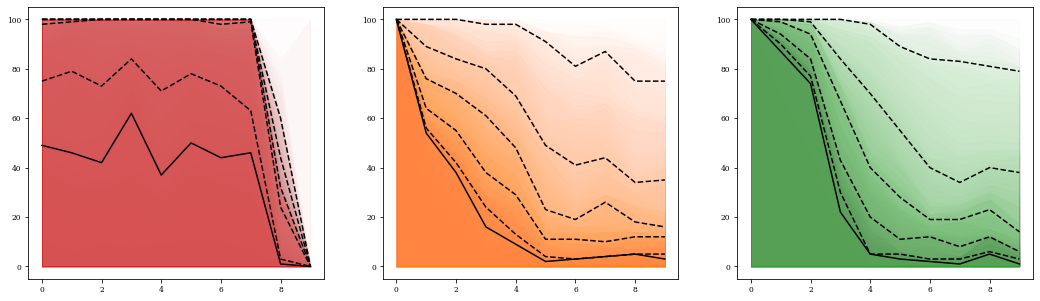

In [30]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for ax, model_name, color in zip(axes, ls_model_name, ls_color):
    data = data_min_dist2goal[model_name]
    success = np.count_nonzero(data <= catchment_radius, axis=1)
    ax.plot(success, c='k')
    for progress in np.arange(0, 1.01, 0.01):
        half = np.count_nonzero(data <= dist_init2goal * progress, axis=1)
        ax.fill_between(np.arange(n_condition), 0, half, color=color, alpha=0.01)
    for progress in np.arange(0.1, 0.91, 0.2):
        half = np.count_nonzero(data <= dist_init2goal * progress, axis=1)
        ax.plot(half, c='k', ls='dashed')

In [31]:
ls_model_name, condcode

(('differential-MB', 'visual-localisor', 'pure-pursuit'), 3)

In [32]:
if condcode == 3: data_min_dist2goal_sense, data_dsim_test2train_sense = data_min_dist2goal, data_dsim_test2train

In [33]:
if condcode == 1: data_min_dist2goal_steer, data_dsim_test2train_steer = data_min_dist2goal, data_dsim_test2train

In [34]:
if condcode == 0: data_min_dist2goal_trunc, data_dsim_test2train_trunc = data_min_dist2goal, data_dsim_test2train

NameError: name 'data_min_dist2goal_trunc' is not defined

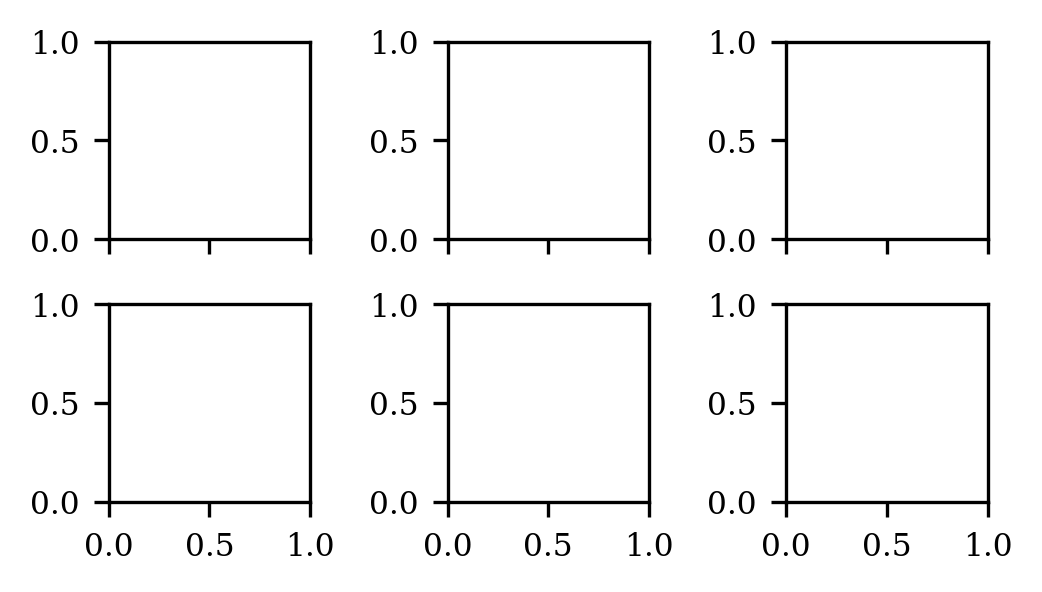

In [35]:
fig, axes = plt.subplots(2, 3, figsize=(3.5, 2), sharex=True, dpi=300, layout='tight')


ls_model_name = 'differential-MB', 'visual-localisor', 'pure-pursuit'
ls_color = 'tab:red', 'tab:orange', 'tab:green'

for axcol, dat_md, dat_dd in zip(axes.T, 
                                 (data_min_dist2goal_sense, data_min_dist2goal_steer, data_min_dist2goal_trunc),
                                 (data_dsim_test2train_sense, data_dsim_test2train_steer, data_dsim_test2train_trunc)):
    for model_name, color in zip(ls_model_name, ls_color):
        if model_name not in dat_md.keys(): continue
        for ax, data in zip(axcol, (dat_md[model_name], dat_dd[model_name])):
            quant = np.nanquantile(data, (0.25, 0.5, 0.75), axis=1)
            avg = np.nanmean(data, axis=1)
            ax.plot(np.arange(n_condition), avg, color=color, ls='dashed')
            ax.plot(np.arange(n_condition), quant[1], color=color, label=model_name)
            ax.fill_between(np.arange(n_condition), quant[0], quant[2], color=color, alpha=0.3)

    
for ax, yl in zip(axes.T[0], 
                  ('goal distance $\delta_g$ (m)', 'path dissimilarity $\delta_\Gamma$ (m)')):
    ax.set_ylabel(yl, fontsize=6)

for ax, tt in zip(axes[0], ('sensing noise', 'steering noise', r'steering noise (if goal at $\diamondsuit$)')):
    ax.set_title(tt, fontsize=6)
#     ax.set_ylim(top=2.6)
    
    
for ax in axes.flatten():
    ax.grid()
    ax.set_xticks(np.arange(n_condition), ls_value, fontsize=6)
    ax.yaxis.set_tick_params(labelsize=6)
    
for ax in axes[1]:
    ax.set_xlabel(r'noise level $\sigma$ (a.u.)', fontsize=6)  


for ax in axes[0, :2]:
    ax.set_ylim(-0.1, 3.6)
axes[0, 2].set_ylim(-0.01, 0.36)

for ax in axes[1, :]:
    ax.set_ylim(-0.01, 0.45)

    
# axes[-1, -1].legend(fontsize=6)

NameError: name 'data_min_dist2goal_trunc' is not defined

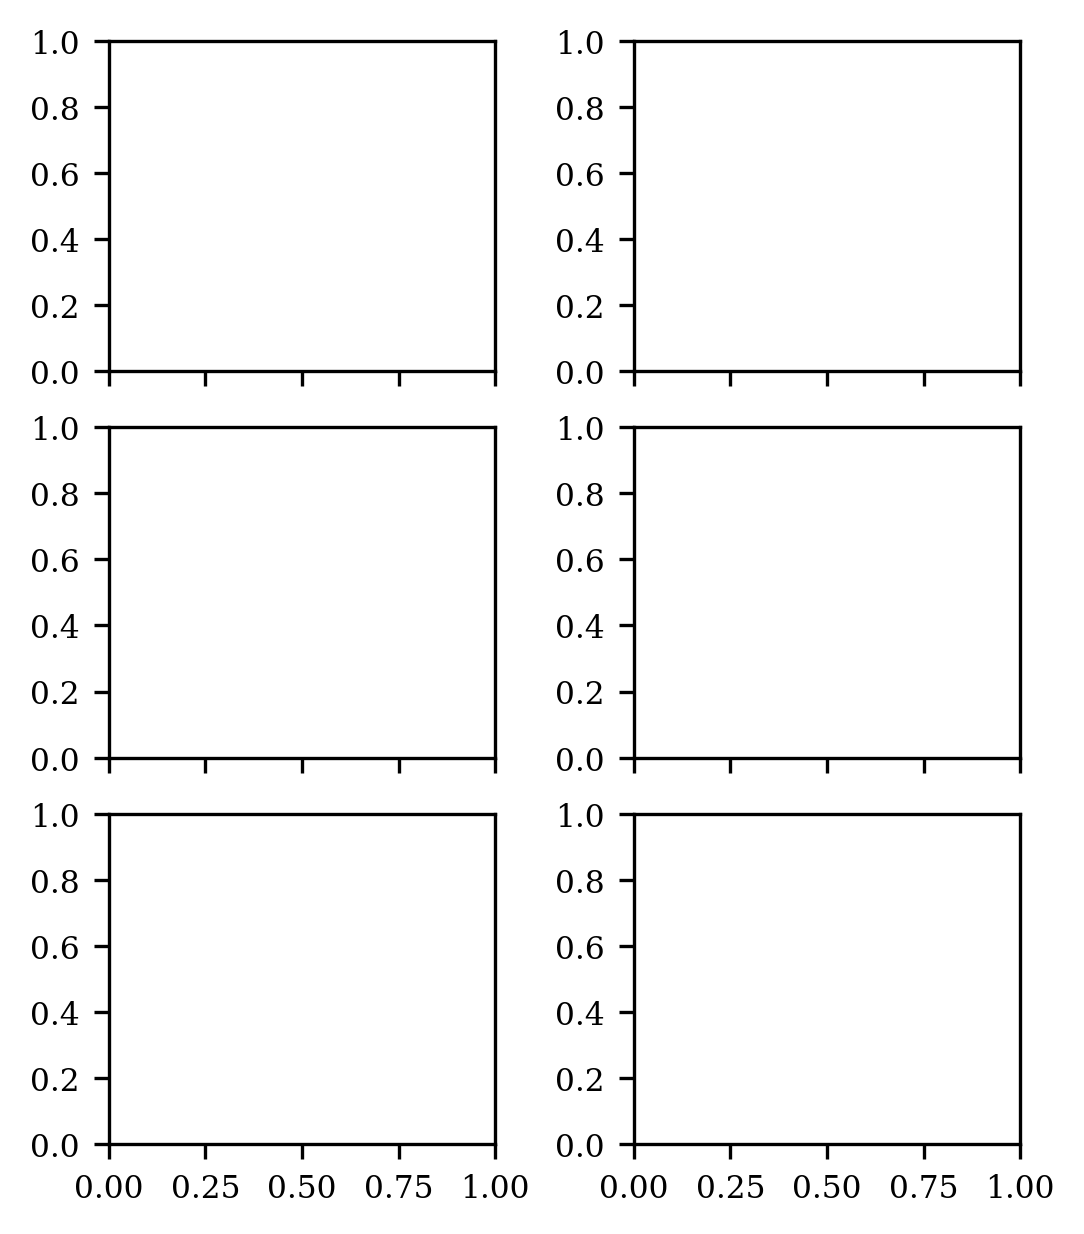

In [36]:
fig, axes = plt.subplots(3, 2, figsize=(3.5, 4), sharex=True, sharey='col', dpi=300, layout='constrained')


ls_model_name = 'differential-MB', 'visual-localisor', 'pure-pursuit'
ls_color = 'tab:red', 'tab:orange', 'tab:green'

for axcol, dat_md, dat_dd in zip(axes, (data_min_dist2goal_sense, data_min_dist2goal_steer, data_min_dist2goal_trunc),
                                 (data_dsim_test2train_sense, data_dsim_test2train_steer, data_dsim_test2train_trunc)):

    for model_name, color in zip(ls_model_name, ls_color):
        for ax, data in zip(axcol, (dat_md[model_name], dat_dd[model_name])):
            quant = np.nanquantile(data, (0.25, 0.5, 0.75), axis=1)
            avg = np.nanmean(data, axis=1)
            ax.plot(np.arange(n_condition), avg, color=color, ls='dashed')
            ax.plot(np.arange(n_condition), quant[1], color=color)
            ax.fill_between(np.arange(n_condition), quant[0], quant[2], color=color, alpha=0.3)
        

    
for ax, yl in zip(axes[0], 
                  ('Goal distance $\delta_g$ (m)', 'Path dissimilarity $\delta_\Gamma$ (m)')):
    ax.set_title(yl, loc='right')

for ax, tt in zip(axes.T[0], ('Sensory noise', 'Motor noise', r'Motor noise (if goal at $\diamondsuit$)')):
    ax.set_ylabel(tt)
    
    
for ax in axes.flatten():
    ax.grid()
    ax.set_xticks(np.arange(n_condition), ls_value, rotation=90)
    ax.yaxis.tick_right()
    
for ax in axes[-1]:
    ax.set_xlabel(r'Noise level $\sigma$')  


    
for model_name, color in zip(model_capitals[1:], ls_color):
    axes[-1, 0].plot([], [], color=color, label=model_name)
fig.legend(ncol=2, loc='upper right', bbox_to_anchor=(1, 0))

complete_figure(fig, axes, 'abcdef')

In [37]:
if condcode == 1: 
    data_path_steer = data_path
elif condcode == 3:
    data_path_sense = data_path

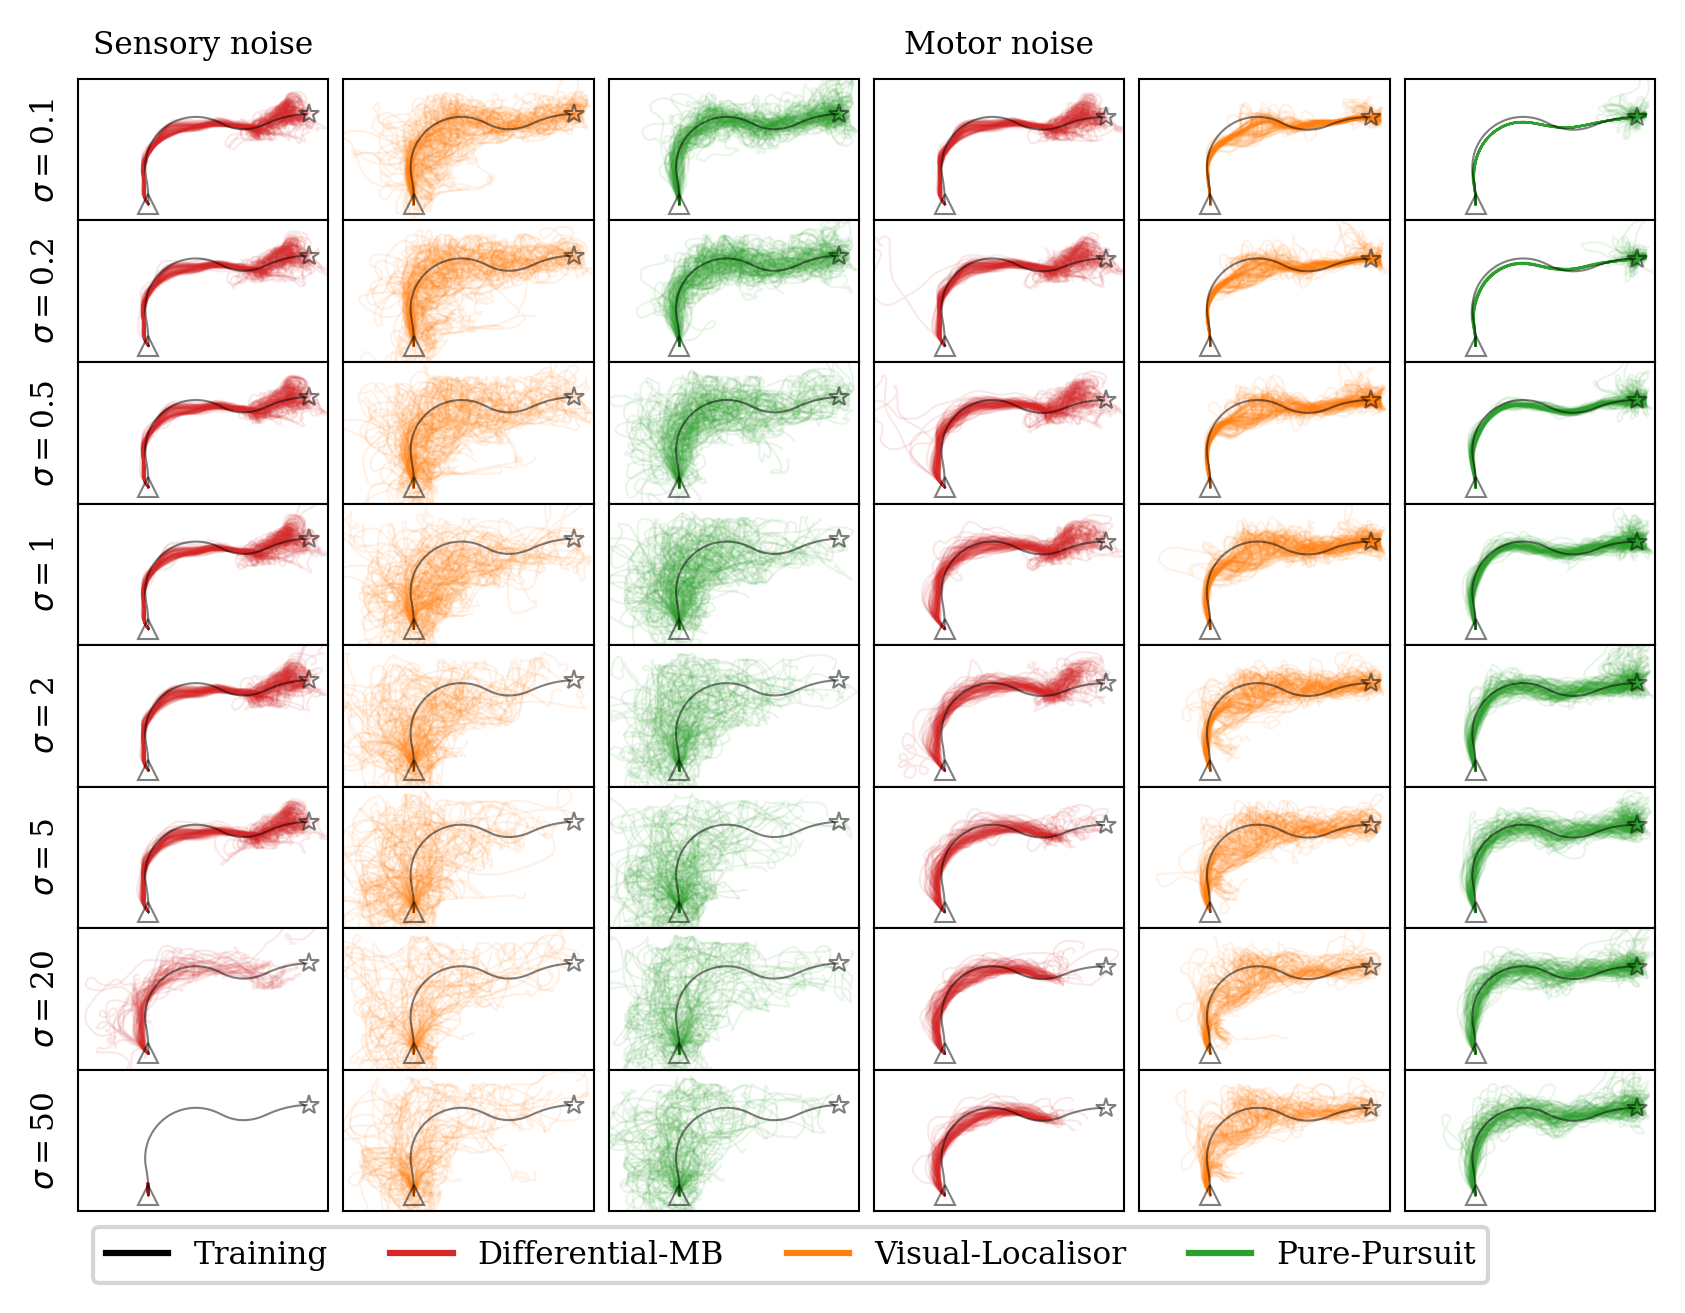

In [50]:
fig, axes = plt.subplots(8, 6, sharex=True, sharey=True, figsize=(figw1, 5), dpi=300)
fig.subplots_adjust(hspace=0, wspace=0)
lw = 0.5
alpha = 0.5
ls_model_name = 'differential-MB', 'visual-localisor', 'pure-pursuit'
ls_color = 'tab:red', 'tab:orange', 'tab:green'
noise_idx = 1, 2, 3, 4, 5, 6, 8, 9

for idx, (model_name, axrow, color) in enumerate(zip(np.tile(ls_model_name, 2), axes.T, np.tile(ls_color, 2))):
    if idx <= 2:
        data_path_col = data_path_sense
    else:
        data_path_col = data_path_steer
        
    for dtp_train, dtp_testtrunc, val, ax in zip(data_path_col[model_name]['train'][noise_idx, :, :, :], 
                                                 data_path_col[model_name]['test_trunc'][noise_idx, :, :, :], 
                                                 [0.1, 0.2, 0.5, 1, 2, 5, 20, 50], 
                                                 axrow):
        for trial_idx, (path_train, path_test_trunc) in enumerate(zip(dtp_train, dtp_testtrunc)):
            ax.plot(-path_test_trunc[1], path_test_trunc[0], c=color, alpha=0.1, lw=lw)#, ls='dotted')
        
        x, y = -path_train[1], path_train[0]
        ax.plot(x[:goal_idx], y[:goal_idx], c='k', alpha=0.5, lw=lw)
        ax.plot(x[0], y[0], marker='^', c='k', mfc='none', markersize=5, markeredgewidth=lw, alpha=alpha)
        ax.plot(x[goal_idx], y[goal_idx], 
                marker='*', c='k', mfc='none', markersize=5, markeredgewidth=lw, alpha=alpha)


    
for ax in axes.flatten():
    ax.set_aspect('equal')
    ax.set_ylim(-0.3, 2.3)
    ax.set_xlim(-1.3, 3.3)
    ax.set_xticks([])
    ax.set_yticks([])
    
    
    plt.setp(ax.spines.values(), lw=0.5)
    
for ax, val in zip(axes.T[0], [0.1, 0.2, 0.5, 1, 2, 5, 20, 50]):
    ax.set_ylabel('$\sigma=${}'.format(val))


for ak, tit in zip((0, 3), ('Sensory noise', 'Motor noise')):
    axes[0, ak].set_title(tit)

    
axes[-1, 0].plot([], [], c='k', label='Training')    
for model_name, color in zip(['Differential-MB', 'Visual-Localisor', 'Pure-Pursuit'], ls_color):
    axes[-1, 0].plot([], [], c=color, label=model_name)
axes[-1, 0].legend(ncol=4, loc='upper left', bbox_to_anchor=(0, 0))
